## Cointegration Method

In our introduction we showed how two price series modeled as random walks with white noise can display movement that is highly correlated, allowing for a statistical arbitrage portfolio to be constructed from the pair.

The basic idea when trying to ascertain if a time series is mean-reverting is to use a statistical test to see if it differs from the behaviour of a random walk. A random walk is a time series where the next directional movement is completely independent of any past movements - in essence the time series has no “memory” of where it has been, nor is its path in any way predictable from historical data. A mean-reverting time series, however, is different. The change in the value of the time series in the next time period is proportional to the current value. Specifically, it is proportional to the difference between the mean historical price and the current price. Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck process. If it can be shown, statistically, that if a price series behaves like an Ornstein-Uhlenbeck series then it will be possible to design a trading strategy around it.

The Ornstein-Uhlenbeck Process is modelled by the following stochastic differential equation:

$$ dx_t = \theta(\mu - x_t)dt + \sigma dW_t $$

Theta is the rate of mean reversion and Wt is standard brownian motion (wiener process).

This equation essentially states that the instantaneous change of the price series at time t in the next continuous time period is proportional to the difference between the mean price and the current price, with the addition of random Gaussian noise.
This equation can be utilised to motivate the definition of the Augmented Dickey-Fuller Test (ADF).

 The ADF test makes use of the fact that if a price series possesses mean reversion, then the next price level will be proportional to the current price level. Mathematically, the ADF is based on the idea of testing for the presence of a unit root in an autoregressive time series sample. 'Autoregressive' indicates a time series whose current values is in some way dependent on its previous values.

A model for a time series known as a linear lag model of order p will now be introduced. This model says that the change in the value of the time series is proportional to a constant, the current time and the previous p values of the time series, along with an error term:

$$ \Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + .... + \delta_{p-1} \Delta y_{t-p+1} + \epsilon_t $$

Here alpha is a constant, beta represents the coefficient of the time trend.

The role of the ADF hypothesis test is to test statistically, whether $\gamma = 0$, which would indicate (with $\alpha = \beta = 0$) that the process is a random walk and thus non mean reverting. Hence, the test considers the null hypothesis that $\gamma = 0$.

If the hypothesis that $\gamma = 0$ can be rejected, then the following movement of the price series is proportional to the current price and therefore we can assume it is unlikely to be a random walk.

The Python Statsmodels library can be used to calculate the Augmented Dickey-Fuller Test. Statsmodels wraps the ADF test in an easy to call function: adfuller. This avoids the test statistic having to be calculated manually.

The whole purpose of using the ADF test and checking for mean reversion is the fact we are looking for a __stationary__ series. Mean reversion = stationarity in a broad sense.

We will test the theory of stationarity on Microsoft prices using the ADF test:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import pandas as pd
import statsmodels.tsa.stattools as ts

data_source = 'yahoo'
start_date = '2015-01-01'
end_date = '2022-06-01'
Microsoft = data.DataReader('MSFT', data_source, start_date, end_date)

df = pd.DataFrame(Microsoft)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,47.439999,46.450001,46.730000,46.450001,21552500.0,40.741421
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,41.013317
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,40.636166
2015-01-06,46.750000,45.540001,46.380001,45.650002,36447900.0,40.039742
2015-01-07,46.459999,45.490002,45.980000,46.230000,29114100.0,40.548454


In [3]:
# ADF test for Microsoft with a lag order value of 1
results = ts.adfuller(df['Adj Close'].tolist(), 1)
print(f"The test statistic is {results[0]}, the p-value is {results[1]}\n")

if results[1] < 0.05:
    print("Reject null hypothesis, series is likely to be mean reverting/stationary")
else:
    print("We do not reject the null hypothesis, the series is unlikely to be mean reverting/stationary")

The test statistic is 0.12060020588072971, the p-value is 0.9674397458105115

We do not reject the null hypothesis, the series is unlikely to be mean reverting/stationary


As we can see the time series for Microsoft prices do not exhibit mean reverting behaviour, it is actually very difficult to find a tradable asset that possesses mean-reverting behaviour. Equities broadly behave like GBMs (Geometric Brownian Motion) and hence render mean-reverting trading strategies with the securities alone difficult to implement profitably.



A good way to test for stationarity/characterise the movement process of a time series is to calculate the Hurst exponent. The goal of the Hurst Exponent is to provide a scalar value that helps identify whether a series is mean reverting, randomly walking or trending. The idea behind the Hurst Exponent calculation is that the variance of a log price series can be used to assess the rate of diffusive behaviour. A critical feature of stationary price series is that the prices within the series diffuse from their initial value at a rate slower than that of a GBM. By measuring the rate of this diffusive behaviour it is possible to identify the nature of the time series and thus detect whether it is mean-reverting.

For an arbitrary time lag τ the variance of τ is given by:

$$ Var(\tau) = \langle {|log(t+\tau) - log(t)|}^2 \rangle $$

The idea is to compare the rate of diffusion to that of a GBM. In the case of a GBM, when $\tau$ is large the variance of $\tau$ is proportional to $\tau:

$$ \langle {|log(t+\tau) - log(t)|}^2 \rangle \sim \tau $

The key insight is that if any sequential price movements possess non-zero correlation (autocorrelation) then the above relationship is invalid. Instead, it can be modified to include an exponent value “2H”, which provides the Hurst Exponent value H:

$$ \langle {|log(t+\tau) - log(t)|}^2 \rangle \sim {\tau}^{2H} $$

It can be seen that if H = 0.5 then the series is a GBM, since it becomes the previous relation. However, if H ̸= 0.5 then trending or mean-reverting behaviour has been identified.

* H < 0.5 - Series is mean reverting
* H = 0.5 The series is Geometric Brownian Motion
* H > 0.5 The series is trending

We will now calculate the Hurst exponent for various price series to develop this idea further:

(Hurst exponent function is based off of a blog post from Dr Tom Starkes website drtomstarke.com)

In [4]:
# create GBM, Mean Reverting and Trending Series

gbm = np.log(np.cumsum(np.random.randn(10000)) + 1000)
mr = np.log(np.random.randn(10000) + 1000)
tr = np.log(np.cumsum(np.random.randn(10000) + 1) + 1000)
msft = np.array(df['Adj Close'].tolist())

def hurst(time_series):

    lags = range(2,100) # range of lag values
    tau = [np.sqrt(np.std((time_series[lag:] - time_series[:-lag]))) for lag in lags]

    # use a linear fit to estimate the Hurst exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    return poly[0] * 2.0

print(f"Hurst(GBM): {hurst(gbm):.2f}")
print(f"Hurst(MR): {hurst(mr):.2f}")
print(f"Hurst(TR): {hurst(tr):.2f}")
print(f"Hurst(MSFT): {hurst(msft):.2f}")

Hurst(GBM): 0.50
Hurst(MR): -0.00
Hurst(TR): 0.92
Hurst(MSFT): 0.42


As we can see, Microsoft prices have a hurst exponent similar to that of Geometric Brownian Motion and much larger than a staionary/mean reverting process

With this information it will be useful to visualize the difference in the two processes: Ornstein Uhlenbeck and Geometric Brownian Motion.

We know from above that the SDE for the Ornstein-Uhlenbeck process is given by:

$$ dx_t = \theta(\mu - x_t)dt + \sigma dW_t $$

The parameters are:
- $\theta$ mean reversion coefficient
- $\mu$ long term mean
- $\sigma$  volatility coefficient

If $2\kappa \theta > \sigma^2$ (Feller condition), the process is always strictly positive

We can apply the Euler Maruyama method to provide a numerical solution for our OU process, details can be found here: [wiki](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)

Applying this method to the OU SDE we obtain:

$$ x_{i+1} = x_i + \kappa (\theta - x_i) \Delta t + \sigma \sqrt{x_i} \Delta W_i $$

Despite the presence of the Feller condition, when we discretize the process, it is possible that $X_i$ becomes negative, creating problems in the evaluation of the square root.
Here I summarize the most common methods to overcome this problem:

1) $ x_{i+1} = x_i + \kappa (\theta - x_i) \Delta t + \sigma \sqrt{x_i^+} \Delta W_i $

2) $ x_{i+1} = x_i + \kappa (\theta - x_i^+) \Delta t + \sigma \sqrt{x_i^+} \Delta W_i $

3) $ x_{i+1} = x_i + \kappa (\theta - x_i) \Delta t + \sigma \sqrt{|x_i|} \Delta W_i $

4) $ x_{i+1} = |x_i + \kappa (\theta - x_i) \Delta t + \sigma \sqrt{x_i} \Delta W_i |$

where ^+ indicates the positive part.
The methods 1) 2) and 3) just resolve the square root problem, but the process can still become negative.
The method 4) prevents this possibility

Lets have a look at the implementation of the **method 4)**

In [5]:
import scipy.stats as ss
np.random.seed(seed=100)

N = 1000        # time steps
paths = 2000      # number of paths
T = 3
T_vec, dt = np.linspace(0,T,N, retstep=True )

theta = 5
mu = 1
sigma = 0.3
std_asy = np.sqrt( mu * sigma**2 /(2*theta) )   # asymptotic standard deviation

X0 = 1.5
X = np.zeros((paths,N))
X[:,0] = X0
W = ss.norm.rvs( loc=0, scale=np.sqrt(dt), size=(paths,N-1) )

for t in range(0,N-1):
    X[:,t+1] = np.abs( X[:,t] + theta*(mu - X[:,t])*dt + sigma * np.sqrt(X[:,t]) * W[:,t] )

X_T = X[:,-1]    # values of X at time T
X_1 = X[1,:]     # a single path

print("Feller condition is: ", 2*theta * mu > sigma**2)

Feller condition is:  True


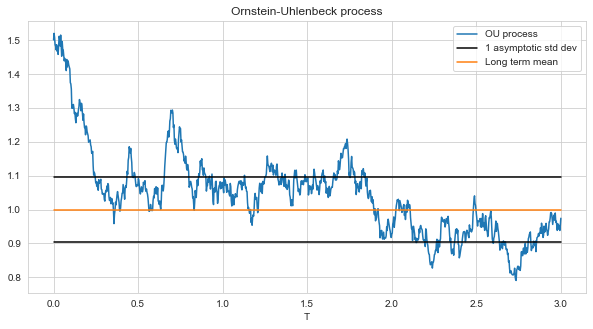

In [6]:
# Plot OU Process
plt.figure(figsize=(10,5))
plt.plot(T_vec, X_1, label="OU process")
plt.plot(T_vec, (mu + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
plt.plot(T_vec, (mu - std_asy)*np.ones_like(T_vec), color="black" )
plt.plot(T_vec, mu*np.ones_like(T_vec), label="Long term mean" )
plt.legend(loc="upper right")
plt.title("Ornstein-Uhlenbeck process")
plt.xlabel("T")
plt.show()

We can see that the OU process starts at 1.5 and then quickly moves towards its long run average of 1.0 where it fluctuates around this mean.

On the other hand, GBM is modelled by the following SDE:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

By applying Itô's lemma on $\log S_t$ it is possible to solve this equation (see the computations [here](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)).
The solution is:

$$ S_t = S_0 e^{(\mu-\frac{1}{2}\sigma^2)t + \sigma W_t} $$

##### Path simulation

If we want to simulate GBM paths, it is enough to simulate Brownian paths (with the adjusted drift) and then take their exponentials:

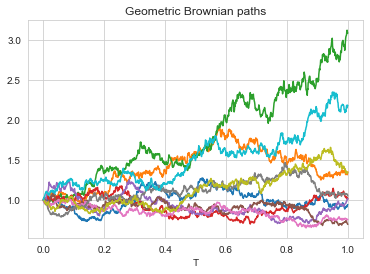

In [7]:
import scipy.stats as ss

np.random.seed(seed=100)
paths=10              # number of paths
steps=1000            # number of time steps
T = 1
T_vec, dt = np.linspace(0, T, steps, retstep=True)
mu = 0.25
sgm = 0.40

X0 = np.zeros((paths,1))        # each path starts at zero
W = ss.norm.rvs( (mu - 0.5 * sgm**2)*dt, np.sqrt(dt)*sgm, (paths,steps-1))
X = np.concatenate((X0,W), axis=1).cumsum(1)

S_T = np.exp(X)
plt.plot(T_vec, S_T.T )
plt.title("Geometric Brownian paths"); plt.xlabel("T")
plt.show()

From both the hurst exponent and the GBM plot we can conclude that stock prices alone do not display mean reverting/stationary behaviour. However, as mentioned in the previous notebook it is possible to create a stationary series from the spread of two cointegrated random walks. We will use this idea on a pair of stocks to develop a pair trading strategy.

The next step is to find a pair of cointegrated stocks to trade, in order to do this we will search for a pair of securities within the same industry since they are often subject to the same risk factors.

In Australia, the financial sector represents a large component of the stock market. We will analyse financial securities on the ASX over an 1 year period and see if we can find a cointegrated pair.

In [8]:
stocklist = ['CBA', 'NAB', 'WBC', 'ANZ', 'SUN', 'MQG', 'BEN', 'AMP', 'BOQ']
stocks = [i + '.AX' for i in stocklist] # need to amend tickers so yahoo can access ASX stocks
start_date = '2021-1-1'
end_date = '2022-1-1'

bank_stocks = data.DataReader(stocks, data_source, start_date, end_date)['Adj Close']
bank_stocks.tail()

Symbols,CBA.AX,NAB.AX,WBC.AX,ANZ.AX,SUN.AX,MQG.AX,BEN.AX,AMP.AX,BOQ.AX
Date,,,,,,,,,
2021-12-22,98.349098,28.050518,20.651367,26.662779,10.858354,200.287079,8.683496,0.94,7.831897
2021-12-23,98.859947,28.226383,20.670868,26.721165,10.848546,200.345932,8.790459,1.00,7.909729
2021-12-28,100.107613,28.578115,20.924377,27.129864,10.946633,203.249359,8.887698,0.99,8.007019
2021-12-29,100.471100,28.646507,20.963379,27.071480,11.044722,203.396484,8.897422,1.00,7.977832
2021-12-30,99.223442,28.177532,20.817123,26.769821,10.858354,201.473938,8.848803,1.01,7.870813


In [9]:
# Function to identify cointegrated pairs in a dataframe
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = ts.coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('NAB.AX', 'MQG.AX'), ('WBC.AX', 'BEN.AX'), ('WBC.AX', 'BOQ.AX'), ('ANZ.AX', 'AMP.AX'), ('BEN.AX', 'AMP.AX'), ('BEN.AX', 'BOQ.AX')]


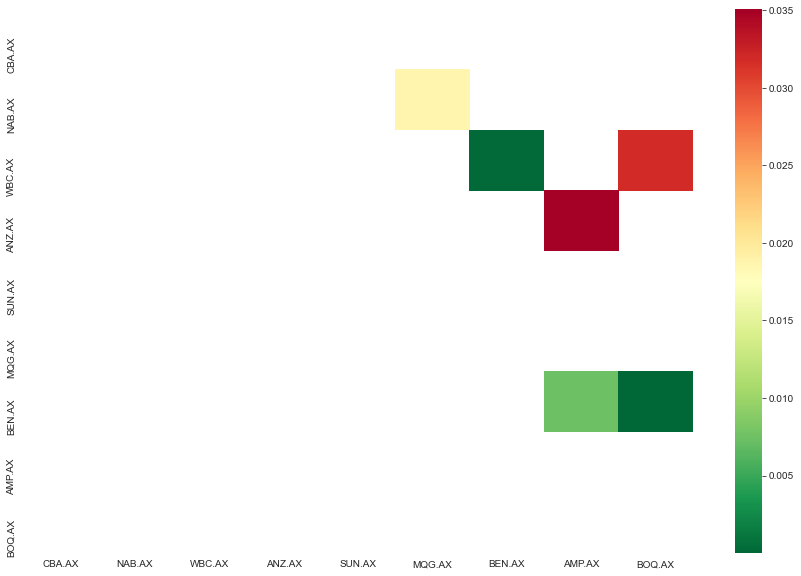

In [10]:
import seaborn as sns

scores, pvalues, pairs = find_cointegrated_pairs(bank_stocks)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pvalues, xticklabels=stocks, yticklabels=stocks, cmap='RdYlGn_r', mask=(pvalues >= 0.05))

print(pairs)

From the heatmap we can see there are various pairs of cointegrated stocks in the financial sector on the ASX. We will choose the pair that has the lowest p-value as the basis of our trading strategy. According to the heatmap, there are two pairs with similar p-values, for our example we will use the Westpac/Bendigo Pair.

The pairs trade is constructed by performing a linear regression between the two adjusted closing price series:

$$ y(t) = \beta x(t) + \epsilon (t) $$

Where y(t) is the adjusted closing price of Westpac stock and x(t) is the adjusted close of Bendigo stock on day t.

Our portfolio will be constructed such that:

$$ spread = y(t) - \beta x(t) $$

This means for each unit of capital we are long one unit of y(t) (Westpac Stock) and short hedge ratio units of x(t) (Bendigo Stock)

This hedge ratio can be calculated using the statsmodels package using the OLS function:

In [11]:
# create dataframe with our pair of cointegrated stocks

trading_pair = bank_stocks[['WBC.AX', 'BEN.AX']]
trading_pair.head()

Symbols,WBC.AX,BEN.AX
Date,,
2021-01-03,18.225410,8.157224
2021-01-04,18.123283,8.131329
2021-01-05,17.984018,8.114062
2021-01-06,18.559652,8.416184
2021-01-07,18.828903,8.424814


Our optimal hedge ratio is 2.567427766821952

The test statistic for the ADF test is -3.2557324206817326, the p-value is 0.016976978380134358

Reject null hypothesis, the series is likely to be mean reverting/stationary


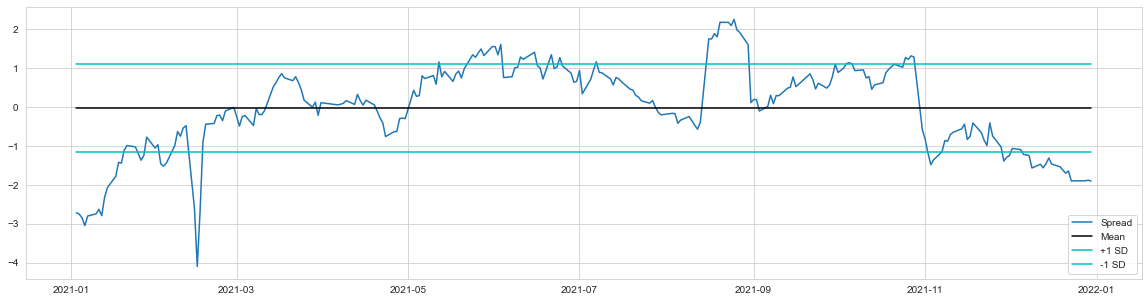

In [12]:
import statsmodels.api as sm

# calculate hedge ratio
model = sm.OLS(trading_pair['WBC.AX'], trading_pair['BEN.AX']).fit()
hedge_ratio = model.params[0]
print(f"Our optimal hedge ratio is {hedge_ratio}\n")

# create portfolio using calculated hedge ratio

spread_hr = trading_pair['WBC.AX'] - hedge_ratio*trading_pair['BEN.AX']
mu = spread_hr.mean()
sgm = spread_hr.std()
NOSD = 1.0

results_spread = ts.adfuller(spread_hr, 1)
print(f"The test statistic for the ADF test is {results_spread[0]}, the p-value is {results_spread[1]}\n")

if results_spread[1] < 0.05:
    print("Reject null hypothesis, the series is likely to be mean reverting/stationary")
else:
    print("We do not reject the null hypothesis, the series is unlikely to be mean reverting/stationary")

plt.figure(figsize=(20,5))
plt.plot(trading_pair.index, spread_hr, label='Spread')
plt.plot(trading_pair.index, len(trading_pair)*[mu], color='k', label='Mean')
plt.plot(trading_pair.index, len(trading_pair)*[mu+NOSD*sgm], color='c', label='+1 SD')
plt.plot(trading_pair.index, len(trading_pair)*[mu-NOSD*sgm], color='c', label='-1 SD')
plt.legend()
plt.show()

We observe that the spread between the two stocks using our hedging ratio generally stays within one standard deviation of the mean, occasionally breaking beyond that. We can use these features to create a trading strategy around this portfolio.

One technique we can implement is using bollinger bands to identify entry signals. Bollinger Bands involve taking a rolling simple moving average (SMA) of a price series and then forming bands surrounding the series that are a scalar multiple of the rolling standard deviation of the price series. The look-back period for the moving average and standard deviation is identical. In essence, they are an estimate of current volatility for a price series. By definition a mean-reverting series will occasionally deviate from its mean and then eventually revert. Bollinger Bands provide a mechanism for entering and exiting trades by employing standard deviation thresholds at which trades can be entered into and exited from.

To generate trades the first task is to calculate a z-score (also known as a standard score) of the current latest spread price. This is achieved by taking the latest portfolio market price, subtracting the rolling mean and dividing by the rolling standard deviation:

$$ Z_{score} = \frac{x_i - \mu_{rolling}}{\sigma_{rolling}} $$

Once this z-score is calculated a position will be opened or closed out under the following conditions:

* z-score < −(z-entry): Long entry
* z-score > +(z-entry): Short entry
* z-score ≥ −(z-exit): Long close
* z-score ≤ +(z-exit): Short close

Where z-score is the latest standardised spread price, z-entry is the trade entry threshold and z-exit is the trade exit threshold.

A long position here means purchasing one share of Westpac and shorting 2.567 shares of Bendigo.

In [13]:
# Create Data Frame of the spread value
spread_hr = pd.Series(spread_hr)
trading_pair['Spread Value'] = trading_pair['WBC.AX'] - hedge_ratio*trading_pair['BEN.AX']
trading_pair.head()

<ipython-input-13-f99d5eaea50e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_pair['Spread Value'] = trading_pair['WBC.AX'] - hedge_ratio*trading_pair['BEN.AX']


Symbols,WBC.AX,BEN.AX,Spread Value
Date,,,
2021-01-03,18.225410,8.157224,-2.717672
2021-01-04,18.123283,8.131329,-2.753315
2021-01-05,17.984018,8.114062,-2.848251
2021-01-06,18.559652,8.416184,-3.048293
2021-01-07,18.828903,8.424814,-2.801199


In [14]:
# Function to create bollinger band values around the spread
def bollinger_bands(df, n, sd):

    data = df['Spread Value']

    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sgm = data.rolling(n, min_periods=n).std()

    BU = pd.Series((B_MA + sd*sgm), name='BU')
    BL = pd.Series((B_MA - sd*sgm), name='BL')
    z_score = pd.Series(((data - B_MA)/sgm), name='Z Score')

    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    df = df.join(z_score)

    return df

In [15]:
spread_df = bollinger_bands(trading_pair, 15, 1.5) # 15 day lookback period and 1 Standard deviation width
spread_df.tail()

,WBC.AX,BEN.AX,Spread Value,B_MA,BU,BL,Z Score
Date,,,,,,,
2021-12-22,20.651367,8.683496,-1.642880,-1.411258,-1.105465,-1.717051,-1.136170
2021-12-23,20.670868,8.790459,-1.898000,-1.466969,-1.143645,-1.790292,-1.999690
2021-12-28,20.924377,8.887698,-1.894146,-1.520393,-1.197157,-1.843629,-1.734425
2021-12-29,20.963379,8.897422,-1.880109,-1.564532,-1.239128,-1.889936,-1.454702
2021-12-30,20.817123,8.848803,-1.901538,-1.609577,-1.292063,-1.927091,-1.379282


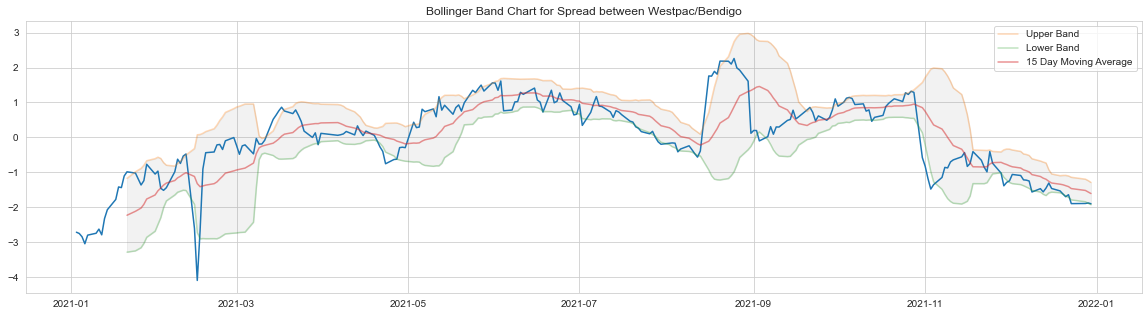

In [16]:
# plot spread with bollinger band values
plt.figure(figsize=(20,5))
plt.plot(spread_df.index, spread_df['Spread Value'])
plt.plot(spread_df.index, spread_df['BU'], alpha=0.3, label='Upper Band')
plt.plot(spread_df.index, spread_df['BL'], alpha=0.3, label='Lower Band')
plt.plot(spread_df.index, spread_df['B_MA'], alpha=0.5, label='15 Day Moving Average')
plt.fill_between(spread_df.index, spread_df['BU'], spread_df['BL'], color='grey', alpha=0.1)
plt.title("Bollinger Band Chart for Spread between Westpac/Bendigo")
plt.legend()
plt.show()

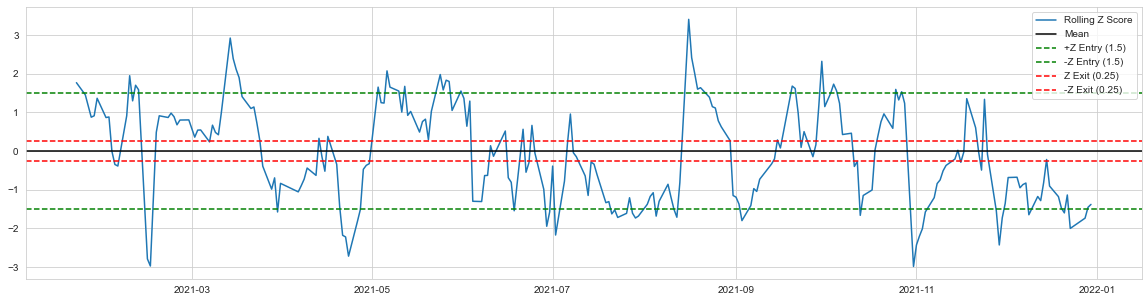

In [17]:
# plot rolling Z Score for signal generation
plt.figure(figsize=(20,5))
plt.plot(spread_df.index, spread_df['Z Score'], label='Rolling Z Score')
plt.axhline(0, color='black', label='Mean')
plt.axhline(1.5, color='green', linestyle='--', label='+Z Entry (1.5)')
plt.axhline(-1.5, color='green', linestyle='--', label='-Z Entry (1.5)')
plt.axhline(0.25, color='red', linestyle='--', label='Z Exit (0.25)')
plt.axhline(-0.25, color='red', linestyle='--', label='-Z Exit (0.25)')
plt.legend()
plt.show()

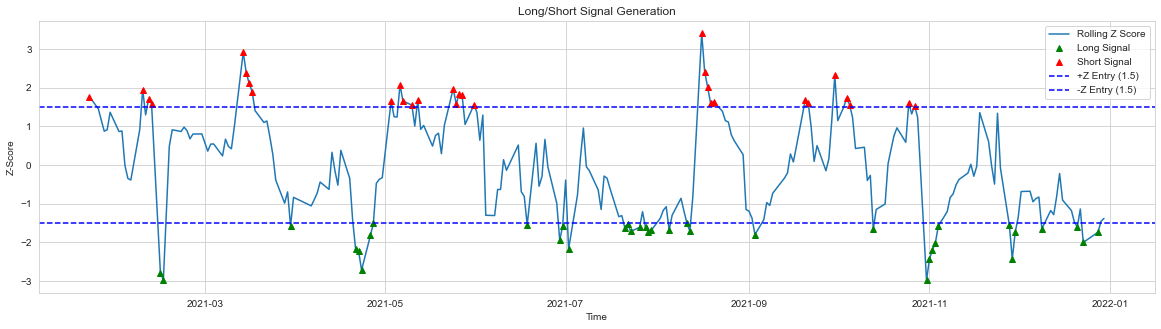

In [18]:

long_entry = spread_df['Z Score'].copy().dropna()
short_entry = spread_df['Z Score'].copy().dropna()

zscores = spread_df['Z Score'].dropna()

# Masking values outside the entry range
long_entry[zscores > -1.5] = 0
short_entry[zscores < 1.5] = 0

long_entry = long_entry.replace(0, np.nan)
short_entry = short_entry.replace(0, np.nan)

# Plot entry signals
plt.figure(figsize=(20,5))
plt.plot(zscores.index, zscores, label='Rolling Z Score')
plt.plot(long_entry.index, long_entry, color='g', linestyle='None', marker='^', label='Long Signal')
plt.plot(long_entry.index, short_entry, color='r', linestyle='None', marker='^', label='Short Signal')
plt.axhline(1.5, color='blue', linestyle='--', label='+Z Entry (1.5)')
plt.axhline(-1.5, color='blue', linestyle='--', label='-Z Entry (1.5)')
plt.title("Long/Short Signal Generation")
plt.ylabel("Z-Score")
plt.xlabel("Time")
plt.legend()
plt.show()

In [19]:
spread_df.head(15)

,WBC.AX,BEN.AX,Spread Value,B_MA,BU,BL,Z Score
Date,,,,,,,
2021-01-03,18.225410,8.157224,-2.717672,NaN,NaN,NaN,NaN
2021-01-04,18.123283,8.131329,-2.753315,NaN,NaN,NaN,NaN
2021-01-05,17.984018,8.114062,-2.848251,NaN,NaN,NaN,NaN
2021-01-06,18.559652,8.416184,-3.048293,NaN,NaN,NaN,NaN
2021-01-07,18.828903,8.424814,-2.801199,NaN,NaN,NaN,NaN
2021-01-10,18.838186,8.407551,-2.747593,NaN,NaN,NaN,NaN
2021-01-11,19.023874,8.433447,-2.628391,NaN,NaN,NaN,NaN
2021-01-12,19.126005,8.537031,-2.792206,NaN,NaN,NaN,NaN
2021-01-13,19.525236,8.511134,-2.326486,NaN,NaN,NaN,NaN


In [20]:
spread_df.to_excel('Test.xlsx')

In [32]:
def trade(S1, S2, n):

    spread = S1 - hedge_ratio*S2

    ma = spread.rolling(n, min_periods=n).mean()
    sgm = spread.rolling(n, min_periods=n).std()
    z_score = (spread - ma)/sgm

    PnL = 0
    count_S1 = 0
    count_S2 = 0

    for i in range(len(spread)):
        if z_score[i] < -1.5:
            PnL += S1[i] - hedge_ratio*S2[i]
            count_S1 -= 1
            count_S2 += hedge_ratio
        elif z_score[i] > 1.5:
            PnL -= S1[i] - hedge_ratio*S2[i]
            count_S1 += 1
            count_S2 -= hedge_ratio
        elif abs(z_score[i]) < 0.5:
            PnL += S1[i]*count_S1 + S2[i]*count_S2
            count_S1 = 0
            count_S2 = 0

        print(PnL)

    return PnL


In [33]:
pnl = trade(spread_df['WBC.AX'], spread_df['BEN.AX'], n=15)
pnl

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.98745248808304
0.98745248808304
0.98745248808304
0.98745248808304
0.98745248808304
0.98745248808304
0.98745248808304
-0.47109334842368256
-0.47109334842368256
-0.47109334842368256
-0.47109334842368256
0.1542661678575996
0.1542661678575996
0.6903711033717315
1.1662860281085337
-1.4395685008740529
-5.538955881689503
-5.538955881689503
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.445601061360005
-6.961731489710445
-7.594397105412899
-8.35325256464547
-9.216881017753245
-9.216881017753245
-9.216881017753245
-9.216881017753245
-9.216881017753245
-7.405498857336973
-7.405498857336973
-7.405498857336973
-7.405498857336973
-7.6156301646917015
-7.6156301646917015
-7.6156301646917015
-7.6156301646917015
-7.61

-44.06302479901588